## Notebook to examine error (standard deviation) of TCS (counts) using bootstrap method
This is estimated for TCS Decadal Survey (DS2010) ; uses all inference values in paragraph/topic (e.g. no minimum_para_threshold)

In [1]:
import pandas as pd
import os, sys
sys.path.append("../src")
from process import *

In [2]:
# Config section
version = '19_2_125_rec1'

# viz 19_2 (125 topics)
topics_to_estimate_errors = [29, 32, 45, 64, 70, 74, 91, 95, 97, 120] # random cherrypick of topics

In [3]:
# load data of inferences by paragraph
topic_distrib_data = open_topic_distrib(version)

In [4]:
data_by_para = topic_distrib_data.drop(['Unnamed: 0'], axis=1)
data_by_para[:1]

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,0.003891,0.004101,0.004221,0.004072,0.003788,0.004016,0.003978,0.003989,0.004242,0.004272,...,0.004053,0.003897,0.003975,0.004133,0.003926,0.003991,0.004122,0.00407,0.004047,0.004007


In [5]:
import numpy as np
import statistics

# sample data for bootstrap
import random
def sample_paragraphs(topic:str, data_by_para:pd.DataFrame, samples_per_run:int=100):
    ''' find TCS or summed total inference from paragraphs for topic '''
    total_inference = 0
    
    keys = list(data_by_para.keys())
    t_size = len(keys)
        
    # random sample, no replacement
    num_topics = len(data_by_para.columns)
    
    # using random sampling of the rows, no replacement
    data = data_by_para
    
    row_seq = list(range(0, len(data)))
    #print (row_seq)

    random_rows = random.sample(row_seq, samples_per_run)
    for random_row in random_rows:
        row_data = data[data.index==random_row]
        value = list(row_data[topic].values)[0]
        total_inference += value

    return total_inference

# sample data for bootstrap
def sample_paragraphs_repl(topic, data_by_para:dict, samples_per_run:int=100):
    
    total_inference = 0
    
    t_size = len(data_by_para.keys())
    
    # random sample with replacement.
    num_topics = len(data_by_para.columns)
    
     # using random sampling of the rows, no replacement
    data = data_by_para
    
    row_seq = list(range(0, len(data)))
    #print (row_seq)

    random_rows = []
    for i in range(0,samples_per_run):
        random_rows.append(random.choice(row_seq))
   
    for random_row in random_rows:
        row_data = data[data.index==random_row]
        value = list(row_data[topic].values)[0]
        total_inference += value

    return total_inference

def bootstrap_estimate (topic:str, data_by_para:dict, \
                       num_times_to_sample:int=10, num_data_samples:int=10000,\
                       replacement:bool=True):
    
    """ Returns the mean and standard deviation for selected topic inference values """
    
    stats = []
    for i in range(0, num_times_to_sample):
        if replacement:
            stats.append(sample_paragraphs_repl(topic, data_by_para, num_data_samples))
        else:
            stats.append(sample_paragraphs(topic, data_by_para, num_data_samples))
    
    #calculate mean, standard deviation
    return statistics.mean(stats), np.std(stats)
    


In [6]:
# overall size (using smallest/first year)
k = list(data_by_para.keys())
len(data_by_para[k[0]])

1009

In [7]:
# choose to sample ~70% of the smallest year size
sample_size = int(len(data_by_para) * 0.7)
sample_size

706

In [8]:
import time
start_time = time.time()

# bootstrap w/replacement is same as w/o replacement according to:
#  https://stats.stackexchange.com/questions/69744/why-at-all-consider-sampling-without-replacement-in-a-practical-application
# when applied to first-order statistics like mean and variance. w/o replacement should
# be used for higher order statistics (e.g. skewness, kurtosis)

# takes about 560 sec per ~18000 data samples per topic 
result = bootstrap_estimate("64", data_by_para, 10, sample_size)
print (f" time to run: %5.2f sec" % (time.time()-start_time))
result

 time to run:  4.57 sec


(4.519099734293013, 0.28573436694244614)

In [9]:
# Now defined above
results = {}
for topic in topics_to_estimate_errors:
    print (f"Doing topic {topic}")
    results[topic] = bootstrap_estimate(str(topic), data_by_para, 10, sample_size, replacement=True)

Doing topic 29
Doing topic 32
Doing topic 45
Doing topic 64
Doing topic 70
Doing topic 74
Doing topic 91
Doing topic 95
Doing topic 97
Doing topic 120


In [10]:
results

{29: (4.4011215621270345, 0.4284817179310549),
 32: (5.183038293647004, 0.6196603411381211),
 45: (4.191087505450037, 0.21230386582481475),
 64: (4.41056143870301, 0.34430382098505014),
 70: (5.922717381442994, 0.9723022401429963),
 74: (7.41460943067702, 1.320918999737916),
 91: (3.7768158259779874, 0.06165354554597288),
 95: (8.314021788159954, 1.6397996436447575),
 97: (3.745194590475982, 0.08377561347061255),
 120: (7.417389236288966, 1.2755335817927222)}

In [11]:
topics = [t for t in results.keys()]
mean  = [results[t][0] for t in topics]
std    = [results[t][1] for t in topics]

# marshal to DataFrame
r_data = pd.DataFrame({'topic':topics, 'mean':mean, 'std':std})

# save results
r_data.to_csv(f'../results/bootstrap_error_est_results_tcs_repl_DS2010_{version}.csv')

# take a look
r_data

,topic,mean,std
0,29,4.401122,0.428482
1,32,5.183038,0.619660
2,45,4.191088,0.212304
3,64,4.410561,0.344304
4,70,5.922717,0.972302
5,74,7.414609,1.320919
6,91,3.776816,0.061654
7,95,8.314022,1.639800
8,97,3.745195,0.083776
9,120,7.417389,1.275534


In [12]:
# overall population mean TCS and associated standard deviation
r_data['mean'].mean(), r_data['std'].mean()

(5.477655705295, 0.6958733370214019)

<Axes: title={'center': 'Bootstrap Error Estimation (TCS, DS2010)'}, xlabel='TCS', ylabel='std'>

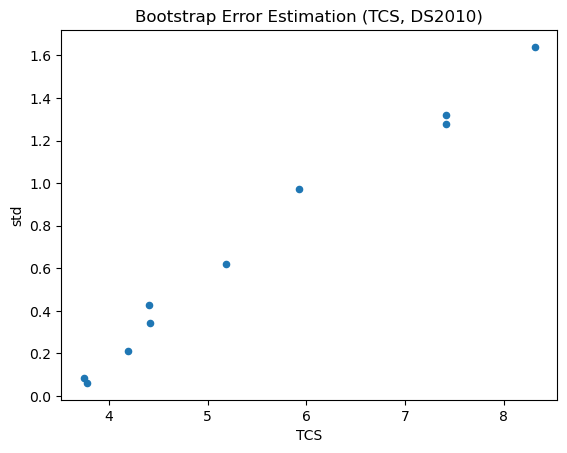

In [13]:
r_data.plot(kind='scatter', x='mean', y='std', xlabel="TCS", title="Bootstrap Error Estimation (TCS, DS2010)")